### EDM inpainting

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid
from torchvision.utils import save_image

In [7]:
from easydict import EasyDict as edict
config = edict()
config.channel_mult = [1, 2, 3, 4]
config.model_channels = 16
config.attn_resolutions = [0,]
config.layers_per_block = 1
config.num_fid_sample = 5000
config.fid_batch_size = 1024
config.channels = 1
config.img_size = 32
config.device = "cuda"
config.sigma_min = 0.002
config.sigma_max = 80.0
config.rho = 7.0 
config.sigma_data = 0.5
device = "cuda"

In [7]:
import sys
sys.path.append("/n/home12/binxuwang/Github/mini_edm")
from train_edm import edm_sampler
from train_edm import EDM
from train_edm import create_model

def load_create_edm(config, model_path):
    # model_path = f"/n/home12/binxuwang/Github/mini_edm/exps/base_mnist_20240129-1342/checkpoints/ema_75000.pth"
    unet = create_model(config)
    edm = EDM(model=unet, cfg=config)
    checkpoint = torch.load(model_path, map_location=device)
    # logger.info(f"loaded model: {model_name}")
    edm.model.load_state_dict(checkpoint)
    for param in edm.model.parameters():
        param.requires_grad = False
    edm.model.eval()
    return edm

epoch = 750000
model_path = f"/n/home12/binxuwang/Github/mini_edm/exps/base_mnist_20240129-1342/checkpoints/ema_{epoch}.pth"
edm = load_create_edm(config, model_path)

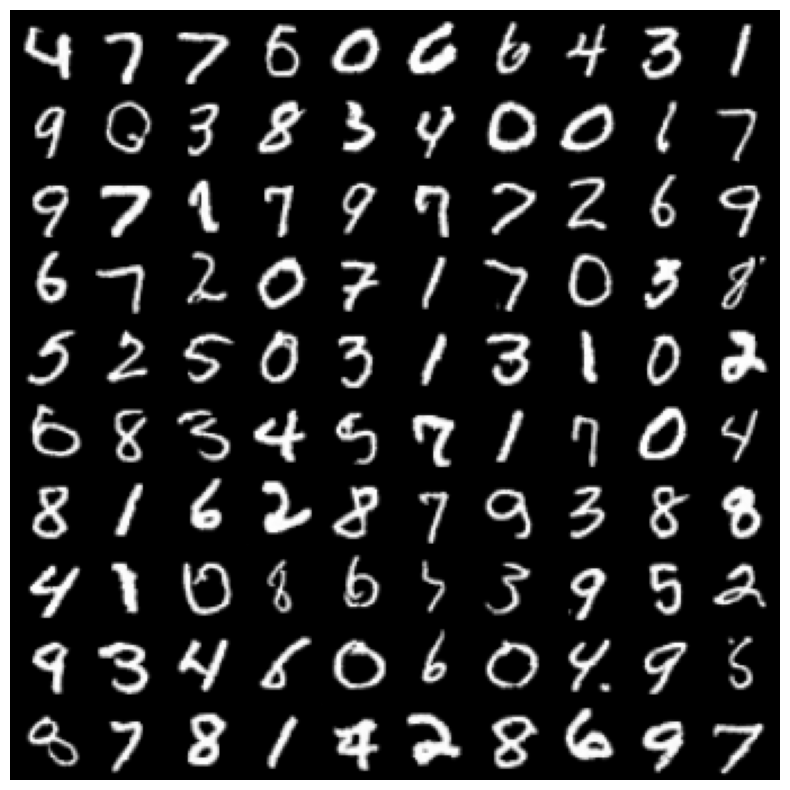

In [8]:
fid_batch_size = 100
config.seed = 42
config.total_steps = 18
with torch.no_grad():
    noise = torch.randn([fid_batch_size, config.channels, config.img_size, config.img_size],
                        generator=torch.cuda.manual_seed(config.seed), device=config.device)
    samples = edm_sampler(edm, noise, num_steps=config.total_steps, use_ema=False).detach().cpu()
    samples.mul_(0.5).add_(0.5)
samples = torch.clamp(samples, 0., 1.).cpu()

plt.figure(figsize=(10, 10))
plt.imshow((make_grid(samples*255.0, nrow=10).permute(1, 2, 0)).numpy().astype(np.uint8))
plt.axis('off')
plt.show()

In [51]:
@torch.no_grad()
def edm_sampler_inpaint(
    edm, latents, target_img, mask, class_labels=None,
    num_steps=18, sigma_min=0.002, sigma_max=80, rho=7,
    use_ema=True, fixed_noise=False
):
    # Adjust noise levels based on what's supported by the network.
    sigma_min = max(sigma_min, edm.sigma_min)
    sigma_max = min(sigma_max, edm.sigma_max)

    # Time step discretization.
    step_indices = torch.arange(num_steps, dtype=torch.float64, device=latents.device)
    t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
    t_steps = torch.cat([edm.round_sigma(t_steps), torch.zeros_like(t_steps[:1])]) # t_N = 0
    initial_noise = torch.randn_like(latents)
    # Main sampling loop.
    x_next = latents.to(torch.float64) * t_steps[0]
    for i, (t_cur, t_next) in enumerate(zip(t_steps[:-1], t_steps[1:])): # 0, ..., N-1
        # x_hat = x_next
        t_hat = t_cur
        noise_perturb = initial_noise if fixed_noise else torch.randn_like(target_img)
        x_hat = (1 - mask[None, None]) * (target_img + noise_perturb * t_cur) + \
                     mask[None, None]  * x_next
        # Euler step.
        denoised = edm(x_hat, t_hat, class_labels, use_ema=use_ema).to(torch.float64)
        d_cur = (x_hat - denoised) / t_hat
        x_next = x_hat + (t_next - t_hat) * d_cur

        # Apply 2nd order correction.
        if i < num_steps - 1:
            denoised = edm(x_next, t_next, class_labels, use_ema=use_ema).to(torch.float64)
            d_prime = (x_next - denoised) / t_next
            x_next = x_hat + (t_next - t_hat) * (0.5 * d_cur + 0.5 * d_prime)

    return x_next



[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


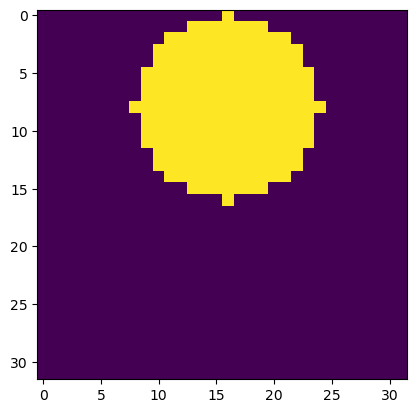

In [12]:
import cv2
import numpy as np

mask = np.zeros((32, 32), dtype=np.uint8)
center = (16, 8)
radius = 8

cv2.circle(mask, center, radius, 1, -1)

print(mask)
plt.imshow(mask)
plt.show()


In [24]:
import torchvision
dataset = torchvision.datasets.MNIST(root='~/Datasets', train=True, download=False, 
                                     transform=torchvision.transforms.Compose([
                                            torchvision.transforms.Resize(32),
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5,), (0.5,))
                                        ]))

In [25]:
dataset[0][0].shape

torch.Size([1, 32, 32])

target class 5


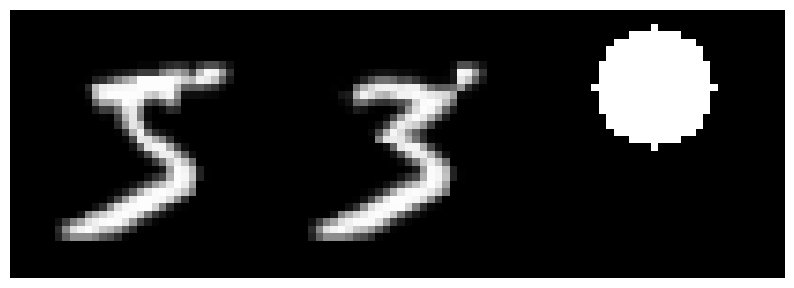

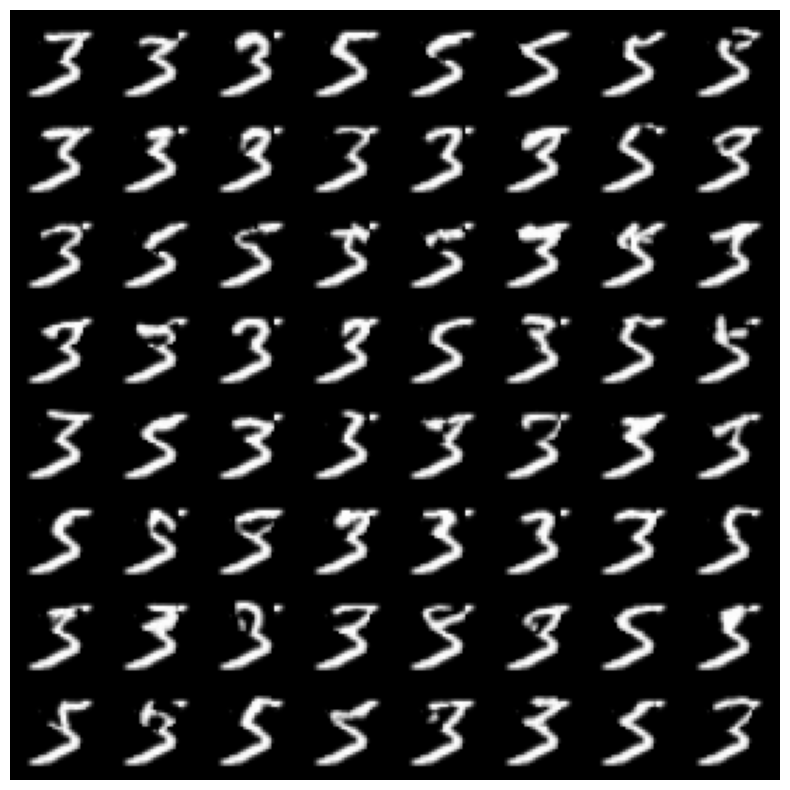

In [57]:
mask_tsr = torch.from_numpy(mask).to(torch.float32).to(config.device)
target_img, target_class = dataset[0]
target_img = target_img.to(config.device)
print("target class", target_class)
fid_batch_size = 64
config.seed = 42
config.total_steps = 36
with torch.no_grad():
    noise = torch.randn([fid_batch_size, config.channels, config.img_size, config.img_size],
                        generator=torch.cuda.manual_seed(config.seed), device=config.device)
    samples = edm_sampler_inpaint(edm, noise, target_img=target_img, mask=mask_tsr,
                                  num_steps=config.total_steps, use_ema=False,
                                  fixed_noise=False).detach().cpu()
    samples.mul_(0.5).add_(0.5)
samples = torch.clamp(samples, 0., 1.).cpu()
plt.figure(figsize=(10, 4))
plt.imshow((make_grid([target_img.mul(0.5).add(0.5).cpu(), 
                       samples[1], 
                       mask_tsr[None].cpu()], nrow=3).permute(1, 2, 0)).numpy())
plt.axis('off')
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow((make_grid(samples*255.0, nrow=8).permute(1, 2, 0)).numpy().astype(np.uint8))
plt.axis('off')
plt.show()

In [39]:
target_img = dataset[0][0].to(config.device)

target class 3


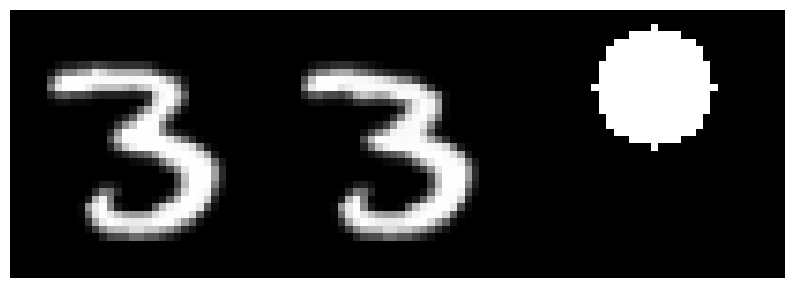

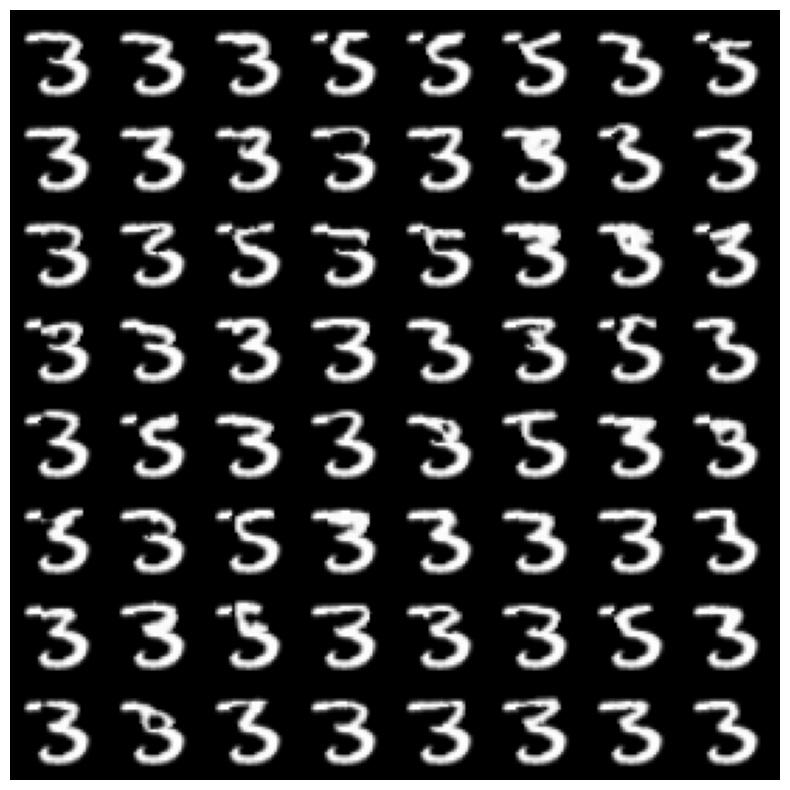

In [61]:
mask_tsr = torch.from_numpy(mask).to(torch.float32).to(config.device)
target_img, target_class = dataset[12]
target_img = target_img.to(config.device)
print("target class", target_class)
fid_batch_size = 64
config.seed = 42
config.total_steps = 35
with torch.no_grad():
    noise = torch.randn([fid_batch_size, config.channels, config.img_size, config.img_size],
                        generator=torch.cuda.manual_seed(config.seed), device=config.device)
    samples = edm_sampler_inpaint(edm, noise, target_img=target_img, mask=mask_tsr,
                                  num_steps=config.total_steps, use_ema=False,
                                  fixed_noise=False).detach().cpu()
    samples.mul_(0.5).add_(0.5)
samples = torch.clamp(samples, 0., 1.).cpu()
plt.figure(figsize=(10, 4))
plt.imshow((make_grid([target_img.mul(0.5).add(0.5).cpu(), 
                       samples[1], 
                       mask_tsr[None].cpu()], nrow=3).permute(1, 2, 0)).numpy())
plt.axis('off')
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow((make_grid(samples*255.0, nrow=8).permute(1, 2, 0)).numpy().astype(np.uint8))
plt.axis('off')
plt.show()